# Analysis 1: Neighbourhood

**<u>Hypothesis:</u> An active neighbourhood has a strong impact on a person’s ability to make connections.**

More specifically, a neighborhood rich in amenities and programs is likely to attract   greater participation in community activities. This increased engagement fosters a stronger sense of community, making it easier and more encouraging for individuals to form social connections, as these opportunities become more accessible and inviting.


**<u>Importance:</u> If the results support the hypothesis, governments/city halls should allocate more resources into building community centres (and etc.) or make them easily accessible within neighborhoods.**

Analysis: 

-Multiple linear regression

-Barplots



In [3]:
import pandas as pd

# Define the CSV URL
csv_url = "https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv"

# Load CSV with low_memory set to False to avoid the mixed type warning
df = pd.read_csv(csv_url, low_memory=False)

# Display the first few rows
print(df.head())




    UNIQUE_id  UNIQUE_num_records ELIGIBLE_consent GEO_residence_canada  \
0  cscs_00001                   1              Yes                  Yes   
1  cscs_00002                   1              Yes                  Yes   
2  cscs_00003                   1              Yes                  Yes   
3  cscs_00005                   1              Yes                  Yes   
4  cscs_00006                   1              Yes                  Yes   

       GEO_province  DEMO_age DEMO_gender DEMO_identity_vetrans  \
0  British Columbia      71.0  Non-binary                   NaN   
1           Ontario      69.0       Woman                   NaN   
2            Quebec      56.0       Woman                   NaN   
3               NaN      54.0       Woman                   NaN   
4           Ontario      30.0         Man          Not Selected   

                            DEMO_identity_indigenous  \
0                                                NaN   
1                                 

In [4]:
# Step 1: Remove rows with NaN values in the satisfaction column
programs_satisfaction_column = 'GEO_canadian_housing_satisfaction_scale_programs'
df_cleaned = df.dropna(subset=[programs_satisfaction_column])

# Verify the cleaned data
print(df_cleaned[programs_satisfaction_column].value_counts())


GEO_canadian_housing_satisfaction_scale_programs
Satisfied                            740
Neither satisfied or dissatisfied    577
Very satisfied                       355
Dissatisfied                         173
Very dissatisfied                     91
Presented but no response             62
Name: count, dtype: int64


In [5]:
# Step 1: Remove NaN values and "Presented but no response"
df_cleaned = df_cleaned[df_cleaned[programs_satisfaction_column].notna()]
df_cleaned = df_cleaned[df_cleaned[programs_satisfaction_column] != 'Presented but no response']

# Step 2: Create a simplified satisfaction column
def simplify_satisfaction(row):
    if row == 'Very satisfied':
        return 'Satisfied'
    elif row == 'Very dissatisfied':
        return 'Dissatisfied'
    else:
        return row

# Apply the function to create a new column
df_cleaned['Simplified_Satisfaction'] = df_cleaned[programs_satisfaction_column].apply(simplify_satisfaction)

# Verify the new value counts for the simplified satisfaction column
print(df_cleaned['Simplified_Satisfaction'].value_counts())








Simplified_Satisfaction
Satisfied                            1095
Neither satisfied or dissatisfied     577
Dissatisfied                          264
Name: count, dtype: int64


In [6]:
# The variables for the past 7 days that you want to evaluate
seven_day_vars = [
    'CONNECTION_social_days_neighbours_p7d', 
    'CONNECTION_social_time_neighbours_p7d', 
    'CONNECTION_social_num_neighbours_p7d'
]

# Filter out any NaN values for the variables we are interested in, for a cleaner analysis
df_filtered = df_cleaned.dropna(subset=seven_day_vars)

# Grouping the dataset by the `Simplified_Satisfaction` and evaluating summary statistics
grouped = df_filtered.groupby('Simplified_Satisfaction')[seven_day_vars]

# Displaying summary statistics such as mean, median, count
summary_stats = grouped.describe()
print(summary_stats)



                                  CONNECTION_social_days_neighbours_p7d  \
                                                                  count   
Simplified_Satisfaction                                                   
Dissatisfied                                                       86.0   
Neither satisfied or dissatisfied                                 152.0   
Satisfied                                                         329.0   

                                                                           \
                                       mean       std  min  25%  50%  75%   
Simplified_Satisfaction                                                     
Dissatisfied                       1.441860  1.985860  0.0  0.0  0.5  2.0   
Neither satisfied or dissatisfied  1.809211  2.044970  0.0  0.0  1.0  3.0   
Satisfied                          1.966565  1.921185  0.0  0.0  2.0  3.0   

                                       CONNECTION_social_time_neighbours_p7d  \
      

In [7]:
# Variable for social time in the past 7 days
social_time_variable = 'CONNECTION_social_time_neighbours_p7d'

# Drop NaN values and select only rows with this variable available
df_social_time_cleaned = df_cleaned.dropna(subset=[social_time_variable])

# Descriptive statistics for each satisfaction level for the social time variable
social_time_summary = df_social_time_cleaned.groupby('Simplified_Satisfaction')[social_time_variable].describe()
print(social_time_summary)


                                   count      mean        std  min  25%  50%  \
Simplified_Satisfaction                                                        
Dissatisfied                        88.0  1.818182   3.257336  0.0  0.0  0.5   
Neither satisfied or dissatisfied  153.0  3.686275  11.227592  0.0  0.0  1.0   
Satisfied                          337.0  3.436202   8.569200  0.0  0.0  1.0   

                                   75%    max  
Simplified_Satisfaction                        
Dissatisfied                       2.0   20.0  
Neither satisfied or dissatisfied  4.0  106.0  
Satisfied                          3.0  100.0  


In [16]:
# Step 1: Remove NaN values and "Presented but no response"
df_cleaned = df_cleaned[df_cleaned[programs_satisfaction_column].notna()]
df_cleaned = df_cleaned[df_cleaned[programs_satisfaction_column] != 'Presented but no response']

# Step 2: Create a simplified satisfaction column
def simplify_satisfaction(row):
    if row == 'Very satisfied':
        return 'Satisfied'
    elif row == 'Very dissatisfied':
        return 'Dissatisfied'
    else:
        return row

# Apply the function to create a new column
df_cleaned['Simplified_Satisfaction'] = df_cleaned[programs_satisfaction_column].apply(simplify_satisfaction)

# Verify the new value counts for the simplified satisfaction column
print(df_cleaned['Simplified_Satisfaction'].value_counts())


Simplified_Satisfaction
Satisfied                            1095
Neither satisfied or dissatisfied     577
Dissatisfied                          264
Name: count, dtype: int64


# Bootstrapping 

### Socialized Days

In [8]:
#Satisfied-Socialized Days (7d)

import numpy as np

# Define a function for bootstrapping
def bootstrap_resample(data, num_resamples=1000, func=np.mean, confidence_level=0.95):
    """
    Perform bootstrapping on a given dataset.
    
    Parameters:
    - data: The dataset to bootstrap (as a Pandas Series or numpy array)
    - num_resamples: Number of bootstrap samples to generate
    - func: Function to apply to each bootstrap sample (default is np.mean)
    - confidence_level: The desired confidence level for the interval (default is 95%)
    
    Returns:
    - mean_estimate: The mean value estimated by the bootstrap samples
    - conf_interval: Confidence interval as a tuple (lower_bound, upper_bound)
    """
    bootstrap_samples = np.random.choice(data, size=(num_resamples, len(data)), replace=True)
    bootstrap_estimates = np.apply_along_axis(func, axis=1, arr=bootstrap_samples)

    # Calculate mean and confidence interval
    mean_estimate = np.mean(bootstrap_estimates)
    lower_bound = np.percentile(bootstrap_estimates, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrap_estimates, (confidence_level + (1 - confidence_level) / 2) * 100)
    conf_interval = (lower_bound, upper_bound)

    return mean_estimate, conf_interval

# Perform bootstrapping for the "Satisfied" group on "CONNECTION_social_days_neighbours_p7d"
satisfied_data = df_cleaned[df_cleaned['Simplified_Satisfaction'] == 'Satisfied']['CONNECTION_social_days_neighbours_p7d'].dropna().values
mean_estimate, conf_interval = bootstrap_resample(satisfied_data, num_resamples=1000)

# Display results
print(f"Bootstrapped mean estimate: {mean_estimate}")
print("Original mean: 1.966565")
print(f"95% Confidence interval: {conf_interval}")



Bootstrapped mean estimate: 1.9599504373177843
Original mean: 1.966565
95% Confidence interval: (1.7638483965014577, 2.1690962099125364)


In [9]:
#Neither-Socialized Days (7d)

import numpy as np

# Extract the 'Neither satisfied or dissatisfied' group for CONNECTION_social_days_neighbours_p7d
neither_satisfied_group = df_cleaned[df_cleaned['Simplified_Satisfaction'] == 'Neither satisfied or dissatisfied'][
    'CONNECTION_social_days_neighbours_p7d'
].dropna()

# Bootstrapping parameters
num_resamples = 1000
original_sample_size = len(neither_satisfied_group)

# Bootstrap function
def bootstrap_mean(data, num_resamples, sample_size):
    boot_means = []
    for _ in range(num_resamples):
        sample = np.random.choice(data, size=sample_size, replace=True)
        boot_means.append(np.mean(sample))
    return np.array(boot_means)

# Run bootstrapping
bootstrap_results = bootstrap_mean(neither_satisfied_group, num_resamples=num_resamples, sample_size=original_sample_size)

# Calculate statistics
bootstrapped_mean = np.mean(bootstrap_results)
confidence_interval = np.percentile(bootstrap_results, [2.5, 97.5])

# Print the results
print(f"Bootstrapped mean estimate: {bootstrapped_mean}")
print("Original mean: 1.809211")
print(f"95% Confidence interval: {confidence_interval}")


Bootstrapped mean estimate: 1.7897452229299362
Original mean: 1.809211
95% Confidence interval: [1.47133758 2.11464968]


In [10]:
#Dissatisfied-Socialized Days (7d)

# Filter the 'Dissatisfied' group data for bootstrapping
dissatisfied_data = df_cleaned[df_cleaned['Simplified_Satisfaction'] == 'Dissatisfied'][
    'CONNECTION_social_days_neighbours_p7d'].dropna()

# Perform bootstrapping for the 'Dissatisfied' group
np.random.seed(42)  # for reproducibility
boot_means_dissatisfied = []

# 1000 bootstrap resamples
for _ in range(1000):
    sample = np.random.choice(dissatisfied_data, size=len(dissatisfied_data), replace=True)
    boot_means_dissatisfied.append(sample.mean())

# Calculate the bootstrapped mean estimate and 95% confidence interval for 'Dissatisfied' group
boot_mean_dissatisfied = np.mean(boot_means_dissatisfied)
conf_interval_dissatisfied = np.percentile(boot_means_dissatisfied, [2.5, 97.5])

print(f"Bootstrapped mean estimate (Dissatisfied group): {boot_mean_dissatisfied}")
print("Original mean: 1.441860")
print(f"95% Confidence interval: {conf_interval_dissatisfied}")


Bootstrapped mean estimate (Dissatisfied group): 1.4430919540229883
Original mean: 1.441860
95% Confidence interval: [1.03448276 1.87356322]


### Socialized Hours

In [11]:
#Satisfied-Socialized Hours (7d)

import numpy as np

# Extract data for the 'Satisfied' group for bootstrapping
satisfied_group_time = df_filtered[df_filtered['Simplified_Satisfaction'] == 'Satisfied'][social_time_variable].dropna()

# Parameters for bootstrapping
bootstrap_iterations = 1000
sample_size = len(satisfied_group_time)

# Bootstrapping to generate mean estimates
bootstrap_means = []
for _ in range(bootstrap_iterations):
    sample = np.random.choice(satisfied_group_time, size=sample_size, replace=True)
    bootstrap_means.append(np.mean(sample))

# Calculate the bootstrapped mean and the 95% confidence interval
bootstrapped_mean = np.mean(bootstrap_means)
confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"Bootstrapped mean estimate (Satisfied group): {bootstrapped_mean}")
print("Original mean: 3.483283")
print(f"95% Confidence interval: {confidence_interval}")


Bootstrapped mean estimate (Satisfied group): 3.459887537993921
Original mean: 3.483283
95% Confidence interval: [2.61990881 4.44703647]


In [12]:
#Neither-Socialized Hours (7d)

# Extract data for the 'Neither satisfied or dissatisfied' group for bootstrapping
neither_group_time = df_filtered[df_filtered['Simplified_Satisfaction'] == 'Neither satisfied or dissatisfied'][social_time_variable].dropna()

# Parameters for bootstrapping
sample_size = len(neither_group_time)  # Set the sample size for the group

# Bootstrapping to generate mean estimates
bootstrap_means = []
for _ in range(bootstrap_iterations):
    sample = np.random.choice(neither_group_time, size=sample_size, replace=True)
    bootstrap_means.append(np.mean(sample))

# Calculate the bootstrapped mean and the 95% confidence interval
bootstrapped_mean = np.mean(bootstrap_means)
confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"Bootstrapped mean estimate (Neither satisfied nor dissatisfied group): {bootstrapped_mean}")
print("Original mean 3.703947")
print(f"95% Confidence interval: {confidence_interval}")


Bootstrapped mean estimate (Neither satisfied nor dissatisfied group): 3.6829144736842108
Original mean 3.703947
95% Confidence interval: [2.13815789 5.90230263]


In [13]:
#Dissatisfied-Socialized Hours (7d)

# Extract data for the 'Dissatisfied' group for bootstrapping
dissatisfied_group_time = df_filtered[df_filtered['Simplified_Satisfaction'] == 'Dissatisfied'][social_time_variable].dropna()

# Parameters for bootstrapping
sample_size = len(dissatisfied_group_time)  # Set the sample size for the group

# Bootstrapping to generate mean estimates
bootstrap_means = []
for _ in range(bootstrap_iterations):
    sample = np.random.choice(dissatisfied_group_time, size=sample_size, replace=True)
    bootstrap_means.append(np.mean(sample))

# Calculate the bootstrapped mean and the 95% confidence interval
bootstrapped_mean = np.mean(bootstrap_means)
confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])

print(f"Bootstrapped mean estimate (Dissatisfied group): {bootstrapped_mean}")
print("Original mean: 1.825581")
print(f"95% Confidence interval: {confidence_interval}")


Bootstrapped mean estimate (Dissatisfied group): 1.8187325581395348
Original mean: 1.825581
95% Confidence interval: [1.1744186  2.52325581]


### Socialized Neighbours

In [14]:
#Satisfied-Socialized Neighbours (7d)

# Extract the satisfied group for the third variable: CONNECTION_social_num_neighbours_p7d
satisfied_values = df_filtered[df_filtered['Simplified_Satisfaction'] == 'Satisfied']['CONNECTION_social_num_neighbours_p7d'].dropna()

# Define the bootstrapping function
def bootstrap(data, num_samples=1000):
    means = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    return means

# Perform bootstrapping with 1000 resamples
bootstrap_means = bootstrap(satisfied_values)

# Calculate the confidence intervals
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

# Print bootstrapped mean, original mean, and confidence interval
bootstrapped_mean = np.mean(bootstrap_means)
original_mean = satisfied_values.mean()

print(f"Satisfied Group - Bootstrapped Mean (Social Num Neighbours 7d): {bootstrapped_mean:.2f}")
print(f"Satisfied Group - Original Mean (Social Num Neighbours 7d): {original_mean:.2f}")
print(f"95% Confidence Interval for Bootstrapped Means: [{lower_bound:.2f}, {upper_bound:.2f}]")


Satisfied Group - Bootstrapped Mean (Social Num Neighbours 7d): 3.43
Satisfied Group - Original Mean (Social Num Neighbours 7d): 3.40
95% Confidence Interval for Bootstrapped Means: [2.67, 4.32]


In [15]:
#Neither-Socialized Neighbours (7d)

# Extract the "Neither satisfied nor dissatisfied" group for the third variable: CONNECTION_social_num_neighbours_p7d
neither_values = df_filtered[df_filtered['Simplified_Satisfaction'] == 'Neither satisfied or dissatisfied']['CONNECTION_social_num_neighbours_p7d'].dropna()

# Perform bootstrapping with 1000 resamples
bootstrap_means = bootstrap(neither_values)

# Calculate the confidence intervals
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

# Print bootstrapped mean, original mean, and confidence interval
bootstrapped_mean = np.mean(bootstrap_means)
original_mean = neither_values.mean()

print(f"Neither Group - Bootstrapped Mean (Social Num Neighbours 7d): {bootstrapped_mean:.2f}")
print(f"Neither Group - Original Mean (Social Num Neighbours 7d): {original_mean:.2f}")
print(f"95% Confidence Interval for Bootstrapped Means: [{lower_bound:.2f}, {upper_bound:.2f}]")


Neither Group - Bootstrapped Mean (Social Num Neighbours 7d): 5.00
Neither Group - Original Mean (Social Num Neighbours 7d): 4.93
95% Confidence Interval for Bootstrapped Means: [3.01, 7.49]


In [17]:
#Dissatisfied-Socialized Hours (7d)

# Extract the "Dissatisfied" group for the third variable: CONNECTION_social_num_neighbours_p7d
dissatisfied_values = df_filtered[df_filtered['Simplified_Satisfaction'] == 'Dissatisfied']['CONNECTION_social_num_neighbours_p7d'].dropna()

# Perform bootstrapping with 1000 resamples
bootstrap_means = bootstrap(dissatisfied_values)

# Calculate the confidence intervals
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

# Print bootstrapped mean, original mean, and confidence interval
bootstrapped_mean = np.mean(bootstrap_means)
original_mean = dissatisfied_values.mean()

print(f"Dissatisfied Group - Bootstrapped Mean (Social Num Neighbours 7d): {bootstrapped_mean:.2f}")
print(f"Dissatisfied Group - Original Mean (Social Num Neighbours 7d): {original_mean:.2f}")
print(f"95% Confidence Interval for Bootstrapped Means: [{lower_bound:.2f}, {upper_bound:.2f}]")


Dissatisfied Group - Bootstrapped Mean (Social Num Neighbours 7d): 1.62
Dissatisfied Group - Original Mean (Social Num Neighbours 7d): 1.62
95% Confidence Interval for Bootstrapped Means: [1.20, 2.08]


# Barplots

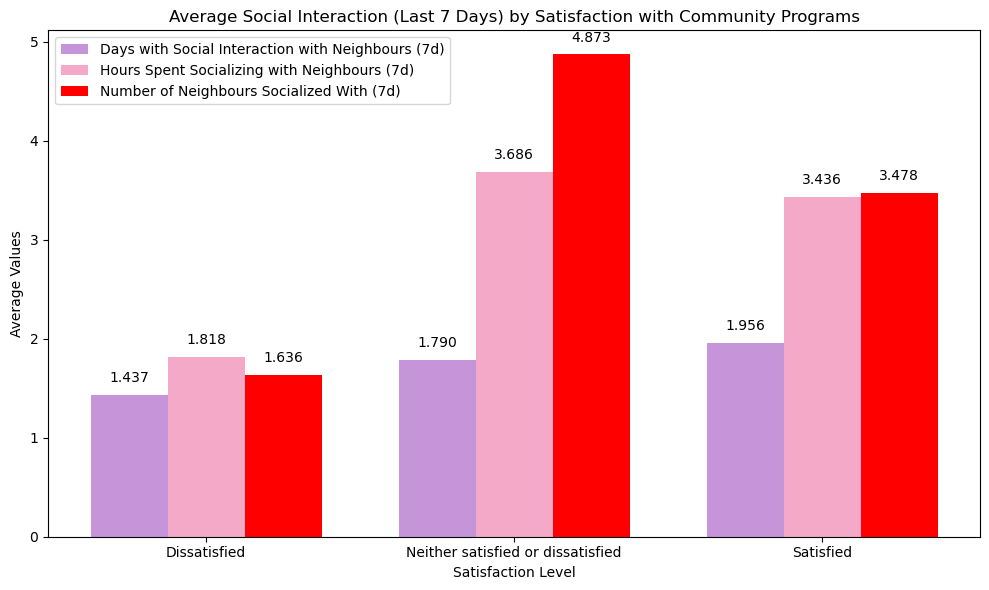

In [20]:
import matplotlib.pyplot as plt

satisfaction_groups = df_cleaned.groupby('Simplified_Satisfaction')

# Calculate means for each group for the specific variables
original_means = satisfaction_groups[['CONNECTION_social_days_neighbours_p7d', 
                                      'CONNECTION_social_time_neighbours_p7d', 
                                      'CONNECTION_social_num_neighbours_p7d']].mean()


# Adjusting the colors to something more aesthetically pleasing
colors = ['#c694d9', '#f4a9c8', '#FF0000']  # light purple, rose, soft purple

# Setting up the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25

# Defining positions for the bars
x_labels = ['Dissatisfied', 'Neither satisfied or dissatisfied', 'Satisfied']
x = range(len(x_labels))
offset = -bar_width

# Plot for CONNECTION_social_days_neighbours_p7d
ax.bar(
    [pos + offset for pos in x], 
    [original_means.loc[group, 'CONNECTION_social_days_neighbours_p7d'] for group in x_labels], 
    width=bar_width, 
    label="Days with Social Interaction with Neighbours (7d)", 
    color=colors[0]
)
offset += bar_width

# Plot for CONNECTION_social_time_neighbours_p7d
ax.bar(
    [pos + offset for pos in x], 
    [original_means.loc[group, 'CONNECTION_social_time_neighbours_p7d'] for group in x_labels], 
    width=bar_width, 
    label="Hours Spent Socializing with Neighbours (7d)", 
    color=colors[1]
)
offset += bar_width

# Plot for CONNECTION_social_num_neighbours_p7d
ax.bar(
    [pos + offset for pos in x], 
    [original_means.loc[group, 'CONNECTION_social_num_neighbours_p7d'] for group in x_labels], 
    width=bar_width, 
    label="Number of Neighbours Socialized With (7d)", 
    color=colors[2]
)

# Add mean value labels above each bar
offset = -bar_width
for idx, group in enumerate(x_labels):
    if group in original_means.index:  # Add a check to make sure the group exists
        # Days Socializing with Neighbours
        ax.text(
            x[idx] + offset, 
            original_means.loc[group, 'CONNECTION_social_days_neighbours_p7d'] + 0.1, 
            f"{original_means.loc[group, 'CONNECTION_social_days_neighbours_p7d']:.3f}", 
            ha='center', 
            va='bottom'
        )
        offset += bar_width

        # Time Socializing with Neighbours
        ax.text(
            x[idx] + offset, 
            original_means.loc[group, 'CONNECTION_social_time_neighbours_p7d'] + 0.1, 
            f"{original_means.loc[group, 'CONNECTION_social_time_neighbours_p7d']:.3f}", 
            ha='center', 
            va='bottom'
        )
        offset += bar_width

        # Number of Neighbours Socialized With
        ax.text(
            x[idx] + offset, 
            original_means.loc[group, 'CONNECTION_social_num_neighbours_p7d'] + 0.1, 
            f"{original_means.loc[group, 'CONNECTION_social_num_neighbours_p7d']:.3f}", 
            ha='center', 
            va='bottom'
        )
        offset = -bar_width

# Setting labels and title
ax.set_xlabel('Satisfaction Level')
ax.set_ylabel('Average Values')
ax.set_title('Average Social Interaction (Last 7 Days) by Satisfaction with Community Programs')
ax.set_xticks([pos for pos in x])
ax.set_xticklabels(x_labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


This bar plot showcases the average levels of social interaction (in terms of days, hours, and number of neighbors) across three satisfaction levels with community programs: "Dissatisfied," "Neutral," and "Satisfied." Interestingly, while respondents who are "Satisfied" report higher interaction levels compared to those who are "Dissatisfied," the "Neutral" group shows the highest levels of social interaction across all three measures. This unexpected trend could suggest unique dynamics within the "Neutral" group, such as exploring social connections while withholding strong opinions on satisfaction.

Bootstrapping was conducted for all bars (using 1000 samples each) to calculate confidence intervals and validate the means. The bootstrapped means closely matched the original means, confirming the reliability of the data. Therefore, the original means were used for this visualization.

**Importance:** This visualization supports the hypothesis that an active neighborhood has a strong impact on a person’s ability to make connections. Social interaction—measured by time spent with neighbors—correlates with satisfaction levels in community programs. Respondents who are either "Neutral" or "Satisfied" with these programs report higher levels of interaction than those who are "Dissatisfied." This highlights how community-driven initiatives and activities can foster an environment that encourages neighborly engagement and connection-building.

Understanding this relationship is crucial because it emphasizes the role of neighborhood dynamics and community resources in shaping social networks. Active and supportive neighborhoods not only contribute to individual well-being but also promote stronger social ties, reducing feelings of isolation. Such findings can inform community planners and policymakers about the importance of fostering active, well-supported neighborhoods to enhance connection opportunities and overall quality of life.

### Does increased spending time with neighbours increase number of close friends?

In [2]:
#Reset the Dataframe
import pandas as pd

# Define the CSV URL
csv_url = "https://raw.githubusercontent.com/pointOfive/stat130chat130/refs/heads/main/CP/CSCS_data_anon.csv"

# Load CSV with low_memory set to False to avoid the mixed type warning
df = pd.read_csv(csv_url, low_memory=False)

In [17]:
# The list of variables we're using for the analysis, now including 'CONNECTION_social_num_neighbours_p7d'
mlr_vars = [
    'CONNECTION_social_days_neighbours_p7d',
    'CONNECTION_social_num_neighbours_p7d',
    'CONNECTION_social_num_close_friends_grouped'
]

# Step 1: Drop NaN values across all selected variables for a clean dataset
df_cleaned_mlr = df.dropna(subset=mlr_vars).copy()

# Step 2: Remove rows where 'CONNECTION_social_num_close_friends_grouped' is 'Presented but no response'
df_cleaned_mlr = df_cleaned_mlr[df_cleaned_mlr['CONNECTION_social_num_close_friends_grouped'] != 'Presented but no response']

# Step 3: Encode 'CONNECTION_social_num_close_friends_grouped' into numerical values
encoding = {
    '1–2': 1,
    '3–4': 2,
    '5 or more': 3
}
df_cleaned_mlr['CONNECTION_social_num_close_friends_grouped'] = df_cleaned_mlr['CONNECTION_social_num_close_friends_grouped'].map(encoding)

# Verify the number of rows remaining after cleaning
print(f"Number of non-null values per variable after cleaning:")
print(df_cleaned_mlr[mlr_vars].count())


Number of non-null values per variable after cleaning:
CONNECTION_social_days_neighbours_p7d          4693
CONNECTION_social_num_neighbours_p7d           4693
CONNECTION_social_num_close_friends_grouped    4693
dtype: int64


In [24]:
import statsmodels.api as sm

# Define the dependent and independent variables
X = df_cleaned_mlr['CONNECTION_social_days_neighbours_p7d']
y = df_cleaned_mlr['CONNECTION_social_num_close_friends_grouped']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())



                                         OLS Regression Results                                        
Dep. Variable:     CONNECTION_social_num_close_friends_grouped   R-squared:                       0.043
Model:                                                     OLS   Adj. R-squared:                  0.043
Method:                                          Least Squares   F-statistic:                     210.3
Date:                                         Thu, 28 Nov 2024   Prob (F-statistic):           1.20e-46
Time:                                                 05:19:49   Log-Likelihood:                -5591.0
No. Observations:                                         4693   AIC:                         1.119e+04
Df Residuals:                                             4691   BIC:                         1.120e+04
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust  

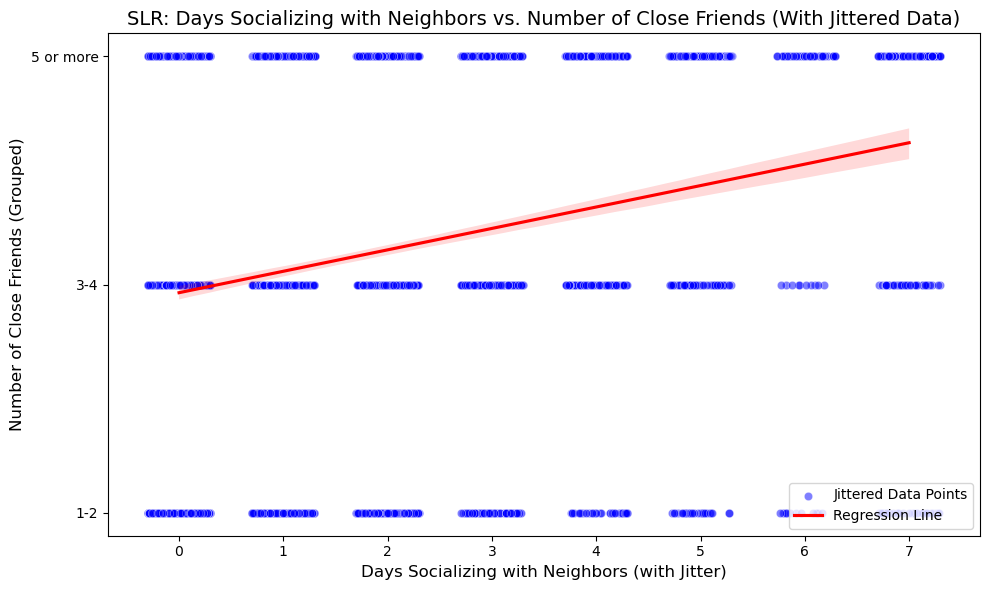

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Adding jitter to the x-axis for better visualization
jittered_days = df_cleaned_mlr['CONNECTION_social_days_neighbours_p7d'] + np.random.uniform(-0.3, 0.3, size=len(df_cleaned_mlr))

plt.figure(figsize=(10, 6))

# Scatter plot with jittered data
sns.scatterplot(
    x=jittered_days,
    y='CONNECTION_social_num_close_friends_grouped',
    data=df_cleaned_mlr,
    alpha=0.5,
    color="blue",
    label="Jittered Data Points"
)

# Regression line
sns.regplot(
    x='CONNECTION_social_days_neighbours_p7d',
    y='CONNECTION_social_num_close_friends_grouped',
    data=df_cleaned_mlr,
    scatter=False,
    color='red',
    label='Regression Line'
)

# Adding titles and labels
plt.title('SLR: Days Socializing with Neighbors vs. Number of Close Friends (With Jittered Data)', fontsize=14)
plt.xlabel('Days Socializing with Neighbors (with Jitter)', fontsize=12)
plt.ylabel('Number of Close Friends (Grouped)', fontsize=12)

# Adjust y-ticks to show labels instead of numbers
plt.yticks([1, 2, 3], ['1-2', '3-4', '5 or more'])

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Even with jittered data points, it's difficult to interpret density. Let's take a look at a heatmap.

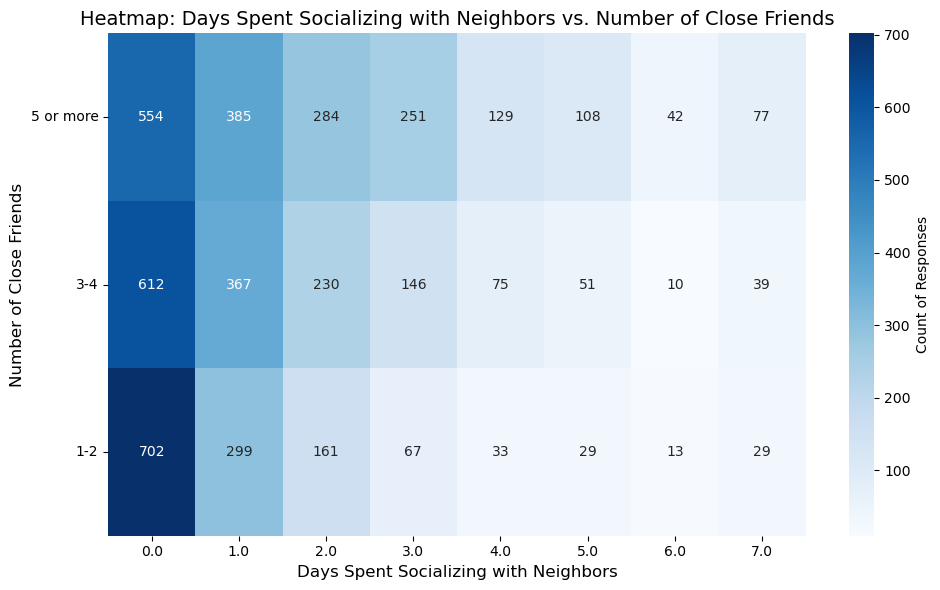

In [23]:
# Invert the y-axis by reversing the order of rows in the heatmap matrix
heatmap_matrix_inverted = heatmap_matrix.iloc[::-1]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_matrix_inverted,
    annot=True, fmt='g', cmap='Blues',
    cbar_kws={'label': 'Count of Responses'}
)

# Add titles and labels
plt.title('Heatmap: Days Spent Socializing with Neighbors vs. Number of Close Friends', fontsize=14)
plt.xlabel('Days Spent Socializing with Neighbors', fontsize=12)
plt.ylabel('Number of Close Friends', fontsize=12)

# Adjust y-ticks to show the original labels
plt.yticks(
    [0.5, 1.5, 2.5],
    ['5 or more', '3-4', '1-2'],  # Labels reversed to match the inverted axis
    rotation=0
)

# Adjust layout
plt.tight_layout()

# Show the heatmap
plt.show()



Interesting. The analysis of the relationship between time spent socializing with neighbors and the number of close friends highlights a notable pattern. The heatmap reveals that at "0 days" spent socializing, the darkest spot—indicating the highest density of responses—is concentrated in the "1-2 close friends" category. However, as the number of days spent socializing increases, this dark spot shifts upwards, with the highest density of responses moving to the "5 or more close friends" category. This shift reflects a clear trend: as the number of days increases, the proportion of individuals with more close friends grows, even though the total number of respondents decreases.

Moreover, this upward movement in density supports the interpretation that more time spent with neighbors is associated with a stronger social network. Although fewer people report spending significant time with neighbors, those who do tend to have a higher number of close friends, suggest a proportional increase in social richness with greater neighborly interaction. The regression line from the earlier graph supports this interpretation.


Now, why is it so dense at 0 days - 1-2 close friends? I believe this may have something to do with this thing called the "friendship filtering phenomenon" yes I totally just made that up. The "friendship filtering phenomenon" is this idea that we all start with lots of friends, but over time, we naturally filter out those who don’t quite stick—leaving us with a few ride-or-die connections. For people with 1-2 close friends, it’s often because they’ve already gone through this process and found the ones who truly matter. They’re not looking to expand; they’re happy with their tight-knit circle.

On the flip side, people with lots of close friends might still be figuring things out—building their network, enjoying new connections, and seeing who sticks. Personality plays a big part too; extroverts might keep a bigger circle while introverts focus on a few deep relationships. At the end of the day, it’s just how friendships evolve for everyone in their own way.

#### Let's view it on a violin plot to better see density with proportion in mind

/tmp/ipykernel_197/1325011369.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_197/1325011369.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_197/1325011369.py:6: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


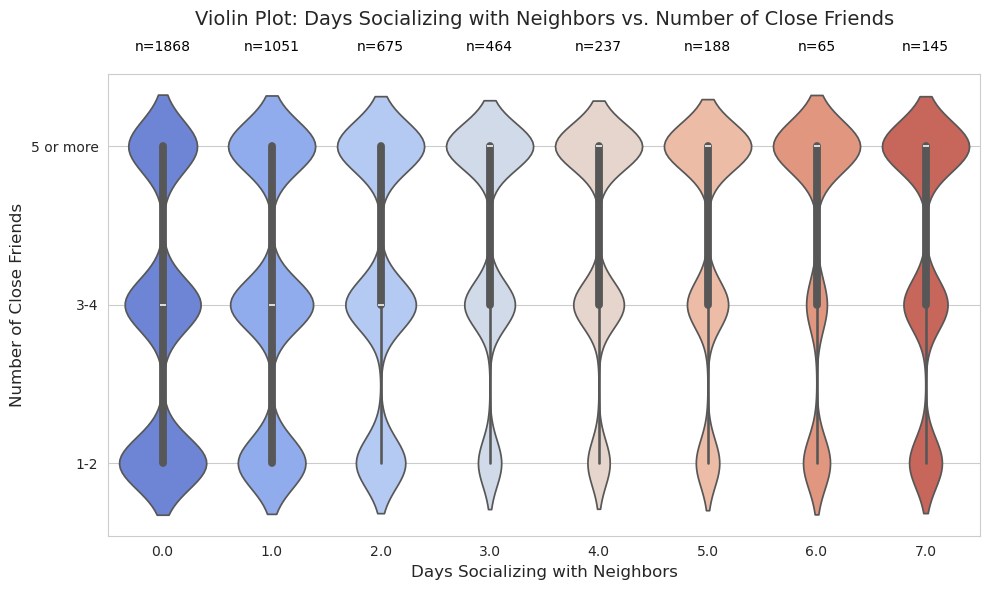

In [41]:
# Set style for the plot
sns.set_style("whitegrid")

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="CONNECTION_social_days_neighbours_p7d",
    y="CONNECTION_social_num_close_friends_grouped",
    data=df_cleaned_mlr,
    inner="box",
    scale="count",
    bw=0.2,
    palette="coolwarm"
)

# Calculate and annotate the total number of respondents for each violin
totals = df_cleaned_mlr.groupby("CONNECTION_social_days_neighbours_p7d").size()
for i, total in enumerate(totals):
    plt.text(i, 3.6, f"n={total}", ha="center", fontsize=10, color="black")  # Adjusted vertical position

# Customize the labels and title
plt.title("Violin Plot: Days Socializing with Neighbors vs. Number of Close Friends", fontsize=14, pad=35)  # Adjusted title position
plt.xlabel("Days Socializing with Neighbors", fontsize=12)
plt.ylabel("Number of Close Friends", fontsize=12)

# Adjust y-ticks to show labels instead of numbers
plt.yticks([1, 2, 3], ["1-2", "3-4", "5 or more"])

# Display the plot
plt.tight_layout()
plt.show()



##### Now, lets see if number of neighbours spent time with has a similar effect.

In [26]:
import statsmodels.api as sm

# Define the dependent and independent variables
X_neighbors = df_cleaned_mlr["CONNECTION_social_num_neighbours_p7d"]
y_close_friends = df_cleaned_mlr["CONNECTION_social_num_close_friends_grouped"]

# Add a constant to the independent variable
X_neighbors = sm.add_constant(X_neighbors)

# Fit the OLS regression model
model_neighbors = sm.OLS(y_close_friends, X_neighbors).fit()

# Display the regression summary
print(model_neighbors.summary())


                                         OLS Regression Results                                        
Dep. Variable:     CONNECTION_social_num_close_friends_grouped   R-squared:                       0.017
Model:                                                     OLS   Adj. R-squared:                  0.017
Method:                                          Least Squares   F-statistic:                     83.45
Date:                                         Thu, 28 Nov 2024   Prob (F-statistic):           9.50e-20
Time:                                                 06:08:21   Log-Likelihood:                -5652.5
No. Observations:                                         4693   AIC:                         1.131e+04
Df Residuals:                                             4691   BIC:                         1.132e+04
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust  

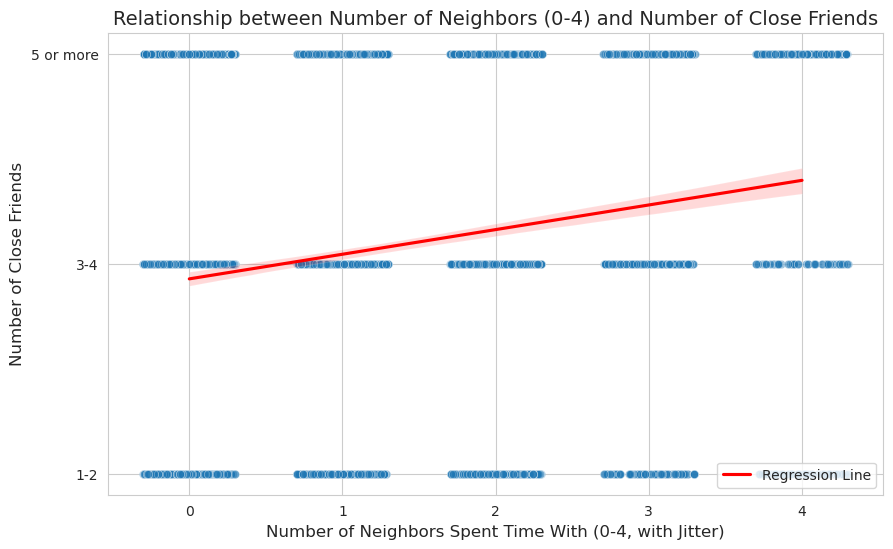

In [36]:
# Filter the data to include only x values of 4 or less
df_filtered = df_cleaned_mlr[df_cleaned_mlr['CONNECTION_social_num_neighbours_p7d'] <= 4]

# Adding jitter for better visualization
jittered_neighbors = df_filtered['CONNECTION_social_num_neighbours_p7d'] + np.random.uniform(-0.3, 0.3, size=len(df_filtered))

plt.figure(figsize=(10, 6))

# Scatter plot with jitter
sns.scatterplot(
    x=jittered_neighbors,
    y='CONNECTION_social_num_close_friends_grouped',
    data=df_filtered,
    alpha=0.5
)

# Adding regression line using seaborn
sns.regplot(
    x='CONNECTION_social_num_neighbours_p7d',
    y='CONNECTION_social_num_close_friends_grouped',
    data=df_filtered,
    scatter=False,
    color='red',
    label='Regression Line'
)

# Adding titles and labels
plt.title('Relationship between Number of Neighbors (0-4) and Number of Close Friends', fontsize=14)
plt.xlabel('Number of Neighbors Spent Time With (0-4, with Jitter)', fontsize=12)
plt.ylabel('Number of Close Friends', fontsize=12)

# Adjusting y-ticks to show the original labels
plt.yticks([1, 2, 3], ['1-2', '3-4', '5 or more'])

plt.legend()
plt.show()


/tmp/ipykernel_197/857055219.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_197/857055219.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_197/857055219.py:12: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


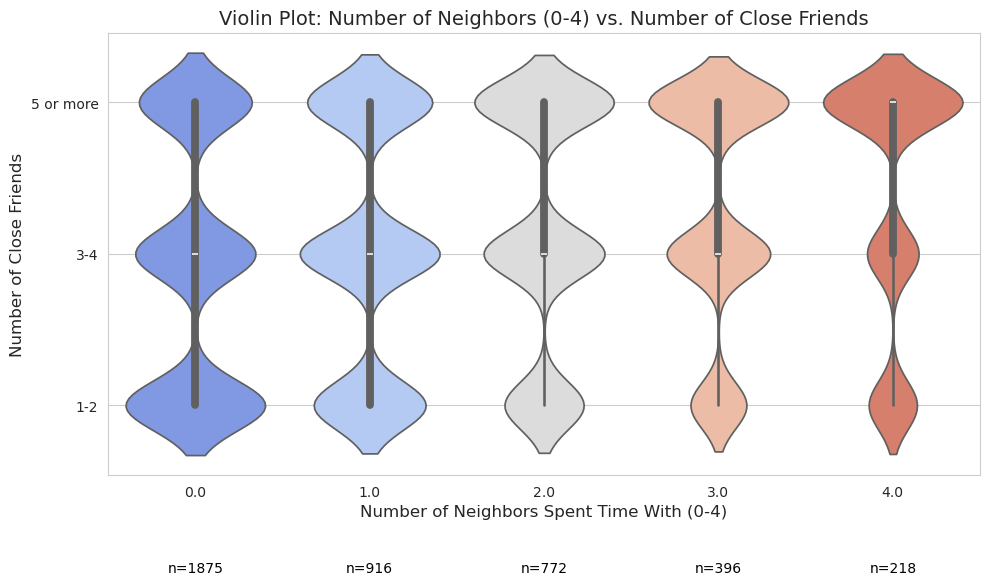

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only rows with 4 or fewer neighbors
filtered_data = df_cleaned_mlr[df_cleaned_mlr["CONNECTION_social_num_neighbours_p7d"] <= 4]

# Set the style for the plot
sns.set_style("whitegrid")

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="CONNECTION_social_num_neighbours_p7d",
    y="CONNECTION_social_num_close_friends_grouped",
    data=filtered_data,
    inner="box",
    scale="count",
    bw=0.2,
    palette="coolwarm"
)

# Get total respondent counts for each category
respondent_counts = (
    filtered_data["CONNECTION_social_num_neighbours_p7d"]
    .value_counts()
    .sort_index()
)

# Add total respondent counts as annotations
for i, (num_neighbors, count) in enumerate(respondent_counts.items()):
    plt.text(
        x=i,  # x-coordinate for annotation
        y=-0.1,  # y-coordinate (just below the x-axis)
        s=f"n={count}",  # text to display
        ha="center",  # center alignment
        fontsize=10,  # font size
        color="black"  # text color
    )

# Customize the labels and title
plt.title("Violin Plot: Number of Neighbors (0-4) vs. Number of Close Friends", fontsize=14)
plt.xlabel("Number of Neighbors Spent Time With (0-4)", fontsize=12)
plt.ylabel("Number of Close Friends", fontsize=12)

# Adjust y-ticks to show original labels
plt.yticks([1, 2, 3], ["1-2", "3-4", "5 or more"])

# Display the plot
plt.tight_layout()
plt.show()


The results here align closely with the earlier findings for the "days spent socializing" variable. We observe a positive relationship: as the number of neighbors spent time with increases (from 0 to 4), the likelihood of having more close friends also tends to increase proportionally. This reinforces the idea that greater social engagement, whether measured by days or the number of neighbors, is associated with a larger circle of close friends.